# Closed-loop control
This notebook explores simple closed-loop control strategies for mobile robots.  To do that, we will build a very simple simulator.

First, usual preparations (see `transforms2d` notebook).

In [1]:
import numpy as np
np.set_printoptions(precision = 4, suppress = True)
import matplotlib.pyplot as plt
import ipywidgets

def mktr(x, y):
    return np.array([[1,0,x],
                     [0,1,y],
                     [0,0,1]])

def mkrot(theta):
    return np.array([[np.cos(theta),-np.sin(theta),0],
                     [np.sin(theta), np.cos(theta),0],
                     [0,0,1]])

def drawf(f, ax = None, name = None):
    """ Draw frame defined by f on axis ax (if provided) or on plt.gca() otherwise """
    xhat = f @ np.array([[0,0,1],[1,0,1]]).T
    yhat = f @ np.array([[0,0,1],[0,1,1]]).T
    if(not ax):
        ax = plt.gca()
    ax.plot(xhat[0,:],xhat[1,:],'r-') # transformed x unit vector
    ax.plot(yhat[0,:],yhat[1,:],'g-') # transformed y unit vector
    if(name):
        ax.text(xhat[0,0],xhat[1,0],name,va="top",ha="center")

## Preparation: a steered bicycle kinematic model

Let's now our robot's kinematic model: a steered bicycle.  It won't be explained in detail; for that, see the `wheeled robots` notebook.

In [2]:
def bctr(v,gamma,L,dt):
    """ returns the pose transform for a motion with duration dt of a steerable
    robot (bicycle model) with back wheel speed v, steering gamma and wheel distance L """
    
    if(np.isclose(gamma,0)): # we are moving straight, R is at the infinity and we handle this case separately
        return mktr(v*dt,0)  # note we translate along x
    
    R = L / np.tan(gamma) # Make sure you understand this!
    omega = v / R         # Make sure you understand this!
    
    return mktr(0,R) @ mkrot(omega * dt) @ mktr(0,-R) 

To make sure we understand it, as usual, we need a function to draw the robot at a given pose.  We will be careful to accurately draw the two wheels, whose sizes don't matter in this context, but whose distance $L$ does.  The front wheel is steered by $\gamma$ radians (positive steers ccw), and we will draw it with the appropriate steering angle.

In [3]:
def drawrobot_bicycle(f, gamma, L, ax = None, alpha = 0.5):
    """ Draw bicycle robot at pose f, with wheel distance L,
    on axis ax (if provided) or on plt.gca() otherwise. """
    
    if(not ax):
        ax = plt.gca()
    
    # This is the chassis of the robot, a thin arrow
    robot = ([[ 0  , 1  , 1  , 0  , 0  ],  # x
              [-0.3,-0.1, 0.1, 0.3,-0.3]]) # y 
    robot = np.array(robot)
    robot = np.vstack((
        robot * L, # scale by L units: back is center of the back wheel; tip is the center of the front wheel
        np.ones((1,robot.shape[1]))))
    # ... and now it's in homogeneous coordinates

    # define back and front wheels
    wheelb = np.array([
        [-L*0.3, +L*0.3], # wheel diameter does not matter. It's now 0.6*L
        [ 0,      0    ],
        [ 1,      1    ]
    ])    
    wheelf = mktr(L,0) @ mkrot(gamma) @ wheelb # make sure you understand this!
    
    # transform robot and both wheels
    robott = f @ robot
    wheelbt = f @ wheelb
    wheelft = f @ wheelf
    
    ax.plot(robott[0,:],robott[1,:],'k-',alpha=alpha)   # Draw the chassis
    ax.plot(wheelbt[0,:],wheelbt[1,:],'k-',alpha=alpha, linewidth = 2) # Draw the back wheel
    ax.plot(wheelft[0,:],wheelft[1,:],'k-',alpha=alpha, linewidth = 2) # Draw the front wheel

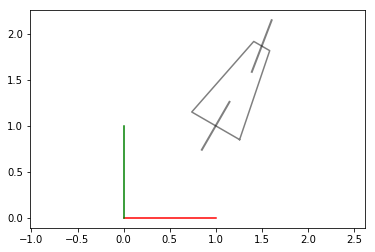

In [4]:
# Let's try our drawing function
drawrobot_bicycle(mktr(1,1)@mkrot(np.pi/3), gamma = +0.1*np.pi/2, L = 1, ax = None, alpha = 0.5)
drawf(np.eye(3))
plt.axis("equal");

Not the best looking bicycle, but will do.

Let's now try our kinematic model.  Does it make sense?

Note that the kinematic model breaks for $\gamma = \pm \pi/2$.  Would it break also in case the powered wheel was the forward one?  We will need to make sure we never steer our bicycle too much.

In [5]:
initial_frame = np.eye(3) # try changing this!
L = 1

@ipywidgets.interact(
    v = ipywidgets.FloatSlider(min=-2,max=+2),
    gamma = ipywidgets.FloatSlider(min=-np.pi/2,max=+np.pi/2,step=np.pi/20))
def f(v, gamma):
    drawf(initial_frame) # Initial frame
    f = bctr(v, gamma, L, 1)
    #drawf(f)
    drawrobot_bicycle(f, gamma, L)
    plt.axis("equal") 

interactive(children=(FloatSlider(value=0.0, description='v', max=2.0, min=-2.0), FloatSlider(value=0.0, descr…

Let's wrap our robot in a class to make a very simple simulator

In [6]:
class BCRobot:
    def __init__(self, initial_pose, L):
        self.pose = initial_pose # will always store the current pose
        self.L = L
        
    def step(self, v, gamma, dt):
        self.pose = self.pose @ bctr(v, gamma, self.L, dt) # this is where the magic happens
        return self.pose
    
    def getxy(self):
        return self.pose[0:2,2] # extracts [x,y] from current pose
    
    def gettheta(self): # sin(theta)      cos(theta)
        return np.arctan2(self.pose[1,0], self.pose[0,0])

In [7]:
# A simple test: moving 2 meters per second for two seconds
robot = BCRobot(np.eye(3), L = 1)
robot.step(v = 2, gamma = 0, dt = 1)
print("t = 1  xy: ",robot.getxy(), " theta: ", robot.gettheta())
robot.step(v = 2, gamma = 0, dt = 1)
print("t = 2  xy: ",robot.getxy(), " theta: ", robot.gettheta())
# .. then steering left will increase theta (turns ccw)
robot.step(v = 2, gamma = 0.1, dt = 1)
print("t = 3  xy: ",robot.getxy(), " theta: ", robot.gettheta())

t = 1  xy:  [2. 0.]  theta:  0.0
t = 2  xy:  [4. 0.]  theta:  0.0
t = 3  xy:  [5.9866 0.2   ]  theta:  0.2006693441709011


## A first trivial control task
Just to fix ideas: we want to control our robot to reach and keep a given desired orientation $\hat{\theta}$.

Let's see if our robot will magically steer in the right direction.  Of course it won't, but this is our blueprint for the simulations that we will run later on.

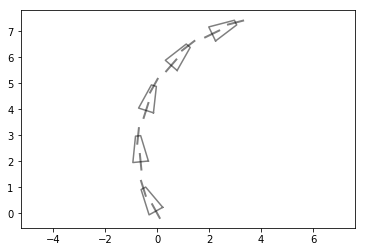

In [8]:
initial_pose = np.eye(3) @ mkrot(np.pi*2/3)
L = 1
robot = BCRobot(initial_pose, L)
maxsteer = np.pi/4 # we will limit our steering to this range
desired_theta = 0

dt = 0.1
ts = np.arange(0,10,dt)
for t in ts: # we simulate 10 seconds
    v = 1     # Full steam ahead
    gamma = -0.2 # We will probably need some guy to steer us in the right direction here
    gamma = np.clip(gamma, -maxsteer, +maxsteer)
    robot.step(v, gamma, dt)
    if(t%2.0 == 0):
        drawrobot_bicycle(robot.pose, gamma, L)
plt.axis("equal");

## Some simple control strategies
Our controllers manipulate control variables (such as steering $\gamma$) based on an input error signal $\epsilon$.
The idea is that the controller should act in such a way to decrease $\epsilon$.

### A random controller
Will output numbers at random in a range (who said our control strategies need to be smart?).

In [9]:
class Random:
    def __init__(self, min_value, max_value):
        self.min_value, self.max_value = min_value, max_value
        
    def step(self, e, dt):
        return np.random.uniform(self.min_value, self.max_value)

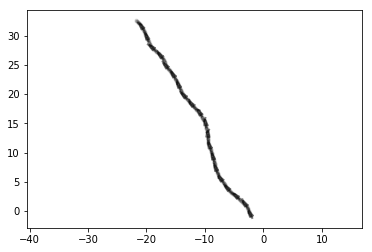

In [10]:
initial_pose = np.eye(3) @ mktr(-2, -1) @ mkrot(np.pi*2/3)
L = 1
robot = BCRobot(initial_pose, L)
maxsteer = np.pi/4 # we will limit our steering to this range
desired_theta = 0
controller = Random(-maxsteer, +maxsteer)

dt = 0.1
ts = np.arange(0,40,dt)
for t in ts: # we simulate 10 seconds
    theta = robot.gettheta()
    error = None # we don't care yet!
    v = 1     # Full steam ahead
    gamma = controller.step(error, dt)
    gamma = np.clip(gamma, -maxsteer, +maxsteer)
    robot.step(v, gamma, dt)
    if(t%2.0 == 0):
        drawrobot_bicycle(robot.pose, gamma, L)
    else:
        plt.plot(*robot.getxy(),".k",alpha=0.1)
plt.axis("equal");

Don't drink and drive.  Look at trajectories for long periods.

### A bangbang controller
... is marginally smarter.
Will output a value if the error is positive, a different one when it is negative. Make sure the steering is in the correct direction!

In [11]:
class Bangbang:
    def __init__(self, value_if_neg, value_if_pos):
        self.value_if_neg = value_if_neg
        self.value_if_pos = value_if_pos
        
    def step(self, e, dt):
        if e>0:
            return self.value_if_pos
        else:
            return self.value_if_neg


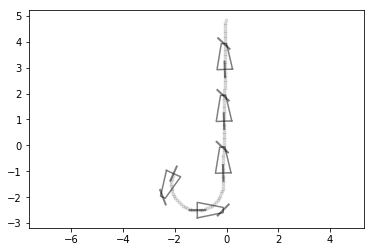

In [12]:
initial_pose = np.eye(3) @ mktr(-2, -1) @ mkrot(-2/3*np.pi)
L = 1
robot = BCRobot(initial_pose, L)
maxsteer = np.pi/4 # we will limit our steering to this range
desired_theta = 0.5*np.pi
controller = Bangbang(value_if_neg = +maxsteer,
                      value_if_pos = -maxsteer)

dt = 0.1
ts = np.arange(0,10,dt)
for t in ts: # we simulate 10 seconds
    theta = robot.gettheta()
    error = theta - desired_theta
    v = 1     # Full steam ahead
    gamma = controller.step(error, dt)
    gamma = np.clip(gamma, -maxsteer, +maxsteer)
    robot.step(v, gamma, dt)
    if(t%2.0 == 0):
        drawrobot_bicycle(robot.pose, gamma, L)
    else:
        plt.plot(*robot.getxy(),".k",alpha=0.1)
plt.axis("equal");

There is a bug in the code above. Can you spot it?

Namely, what happens when desired theta is different than 0?  Or $\pi$, or even $2\pi$? Also try different initial orientations.

The problem is that `error = theta - desired_theta` is not what we want.  A proper angle difference is implemented as follows.  Make sure you understand the sign of the resulting angles.  The result is positive is `angle1` is obtained by rotating `angle2` ccw by at most $\pi$.  The output is always $[-\pi, \pi]$

In [13]:
def angle_difference(angle1, angle2):
    return np.arctan2(np.sin(angle1-angle2), np.cos(angle1-angle2))

assert(np.isclose(angle_difference(0.5*np.pi, 0),  0.5*np.pi))
assert(np.isclose(angle_difference(1.5*np.pi, 0), -0.5*np.pi))
assert(np.isclose(angle_difference(np.pi*-2/3, np.pi*2/3), np.pi*2/3))
assert(np.isclose(angle_difference(0, 2*np.pi), 0))

angle_difference(0, 4*np.pi+0.2)

-0.19999999999999882

Let's correct our code

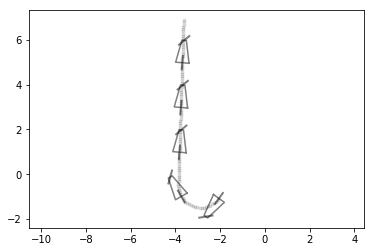

In [14]:
initial_pose = np.eye(3) @ mktr(-2, -1) @ mkrot(-np.pi*2/3)
L = 1
robot = BCRobot(initial_pose, L)
maxsteer = np.pi/4 # we will limit our steering to this range
desired_theta = 0.5*np.pi
controller = Bangbang(value_if_neg = +maxsteer,
                      value_if_pos = -maxsteer)

dt = 0.1
ts = np.arange(0,10,dt)
for t in ts: # we simulate 10 seconds
    theta = robot.gettheta()
    error = angle_difference(theta, desired_theta)
    v = 1     # Full steam ahead
    gamma = controller.step(error, dt)
    gamma = np.clip(gamma, -maxsteer, +maxsteer)
    robot.step(v, gamma, dt)
    if(t%2.0 == 0):
        drawrobot_bicycle(robot.pose, gamma, L)
    else:
        plt.plot(*robot.getxy(),".k",alpha=0.1)
plt.axis("equal");

Make sure you understand the drawbacks of the Bangbang controller.  E.g., what happens when you increase the `dt`?

### A PID controller
A PID controller implements the following formula.
$$\text{output} = K_p \epsilon + K_d \frac{d \epsilon}{d t} + K_i \int{\epsilon(t) dt}$$
Let's write it down in code.

In [15]:
class PID:
    
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.last_e = None
        self.sum_e = 0
        
    def step(self, e, dt):
        """ dt should be the time interval from the last method call """
        if(self.last_e is not None):
            derivative = (e - self.last_e) / dt
        else:
            derivative = 0
        self.last_e = e
        self.sum_e += e * dt
        return self.Kp * e + self.Kd * derivative + self.Ki * self.sum_e

Let's start with a P controller, i.e. $K_d = K_i = 0$.  Experiment with different values for $K_d$. 
Try to predict: should $K_d$ be positive or negative?  What if we get the sign wrong?  Can you break the robot by setting a very large (in absolute value) $K_d$?

Note: we instrumented the code below to save the error values and control outputs, so we can plot them.

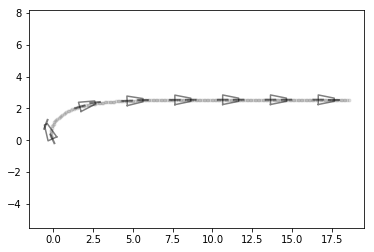

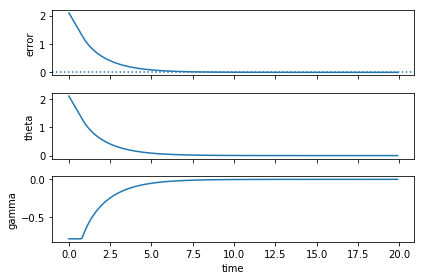

In [16]:
initial_pose = np.eye(3) @ mktr(0, 0) @ mkrot(np.pi*2/3)
L = 1
robot = BCRobot(initial_pose, L)
maxsteer = np.pi/4 # we will limit our steering to this range
desired_theta = 0
controller = PID(-0.6,0,0)

dt = 0.1
ts = np.arange(0,20,dt)
errors, thetas, gammas = [], [], []
for t in ts: # we simulate 10 seconds
    theta = robot.gettheta()
    error = angle_difference(theta, desired_theta)
    v = 1     # Full steam ahead
    gamma = controller.step(error, dt)
    gamma = np.clip(gamma, -maxsteer, +maxsteer)
    robot.step(v, gamma, dt)
    # Log everything
    errors.append(error)
    thetas.append(theta)
    gammas.append(gamma)
    # Draw
    if(t%3 == 0):
        drawrobot_bicycle(robot.pose, gamma, L)
    else:
        plt.plot(*robot.getxy(),".k",alpha=0.1)
plt.axis("equal");

fig, axs = plt.subplots(nrows = 3, sharex = True)
axs[0].plot(ts,errors)
axs[0].axhline(y=0, linestyle = ":")
axs[0].set(ylabel = "error")
axs[1].plot(ts,thetas)
axs[1].set(ylabel = "theta")
axs[2].plot(ts,gammas)
axs[2].set(ylabel = "gamma",
           xlabel = "time")
plt.tight_layout()

It turns out we don't need anything more than a P controller to solve this problem.  Let's now move to a more difficult task, where we won't be so lucky.

## Lane following
We want to steer our bicycle to stay on the $y=0$ line, going right.  We assume we start "close enough" to the lane, and going in the correct direction.  We will use the y coordinate of the robot as an error signal. After all, we want to keep that to 0.

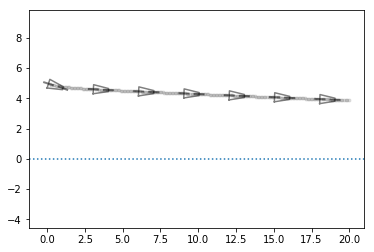

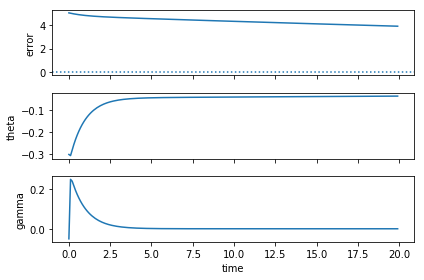

In [17]:
initial_pose = np.eye(3) @ mktr(0, +5) @ mkrot(-0.3)
L = 1
robot = BCRobot(initial_pose, L)
maxsteer = np.pi/4 # we will limit our steering to this range
desired_y = 0
controller = PID(-0.01, 0, 0-1)

dt = 0.1
ts = np.arange(0,20,dt)
errors, thetas, gammas = [], [], []
for t in ts: # we simulate 10 seconds
    theta = robot.gettheta()
    x, y = robot.getxy()
    error = y - desired_y
    v = 1     # Full steam ahead
    gamma = controller.step(error, dt)
    gamma = np.clip(gamma, -maxsteer, +maxsteer)
    robot.step(v, gamma, dt)
    # Log everything
    errors.append(error)
    thetas.append(theta)
    gammas.append(gamma)
    # Draw
    if(t%3 == 0):
        drawrobot_bicycle(robot.pose, gamma, L)
    else:
        plt.plot(*robot.getxy(),".k",alpha=0.1)
plt.axhline(y = desired_y, linestyle = ":") # our "lane"
plt.axis("equal");

fig, axs = plt.subplots(nrows = 3, sharex = True)
axs[0].plot(ts,errors)
axs[0].axhline(y=0, linestyle = ":")
axs[0].set(ylabel = "error")
axs[1].plot(ts,thetas)
axs[1].set(ylabel = "theta")
axs[2].plot(ts,gammas)
axs[2].set(ylabel = "gamma",
           xlabel = "time")
plt.tight_layout()

Experiment a lot with the controller parameters for the simulation above! Can you manage using $K_p$ alone? Why?  What if `dt` was really short?

What happens if you set $K_d \neq 0$ but leave $K_p = K_i = 0$?  Can we stay on the lane?  What is the effect of $K_d$ in practice?

Suggestion: don't mess with $K_i$ yet.

Now, before you continue, take your best parameters and change the initial pose of the robot so it's not so close to the lane, or it's oriented wrong.  Can you find parameters that work reasonably well?  Try for some time, then think about the fundamental issue we have.  Wouldn't everything be simpler if we could act on $\theta$ instead of $\gamma$?

### A hierarchical architecture

We already know we can use a very simple controller to manipulate $\gamma$ in order to achieve a desired $\hat{\theta}$.  Why not to use that?

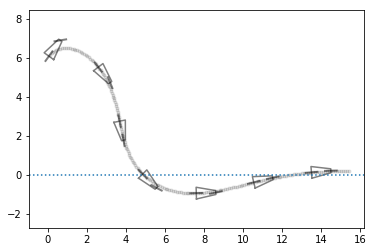

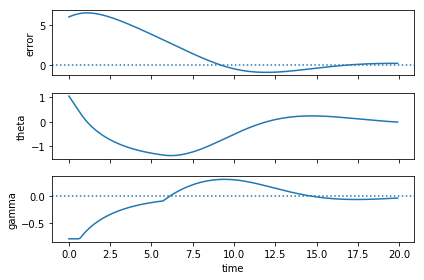

In [18]:
initial_pose = np.eye(3) @ mktr(0, 6) @ mkrot(np.pi/3)
L = 1
robot = BCRobot(initial_pose, L)
maxsteer = np.pi/4  # we will limit our steering to this range
desired_y = 0
# decides a desired theta to achieve desired y (high level)
y_controller = PID(-0.5, 0, 0)
# controls gamma to achieve the desired theta (low level)
theta_controller = PID(-0.4, 0, 0)

dt = 0.1
ts = np.arange(0, 20, dt)
errors, thetas, gammas = [], [], []
for t in ts:  # we simulate 10 seconds
    theta = robot.gettheta()
    x, y = robot.getxy()
    y_error = y - desired_y
    desired_theta = y_controller.step(y_error, dt)
    desired_theta = np.clip(desired_theta, -np.pi/2, +np.pi/2)
    theta_error = angle_difference(theta, desired_theta)

    gamma = theta_controller.step(theta_error, dt)
    gamma = np.clip(gamma, -maxsteer, +maxsteer)
    robot.step(1, gamma, dt)

    # Log everything
    errors.append(y_error)
    thetas.append(theta)
    gammas.append(gamma)
    # Draw
    if(t % 3 == 0):
        drawrobot_bicycle(robot.pose, gamma, L)
    else:
        plt.plot(*robot.getxy(), ".k", alpha=0.1)
plt.axhline(y=desired_y, linestyle=":")  # our "lane"
plt.axis("equal")

fig, axs = plt.subplots(nrows=3, sharex=True)
axs[0].plot(ts, errors)
axs[0].axhline(y=0, linestyle=":")
axs[0].set(ylabel="error")
axs[1].plot(ts, thetas)
axs[1].set(ylabel="theta")
axs[2].plot(ts, gammas)
axs[2].set(ylabel="gamma",
           xlabel="time")
axs[2].axhline(y=0, linestyle=":")
plt.tight_layout()

## Reaching a position
We just use two controllers in parallel: one for velocity (driven by distance to target), one for steering (driven by angle to target)

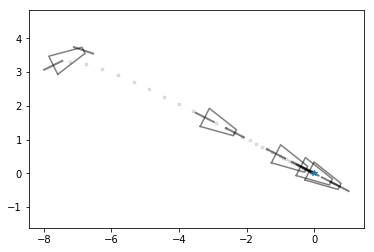

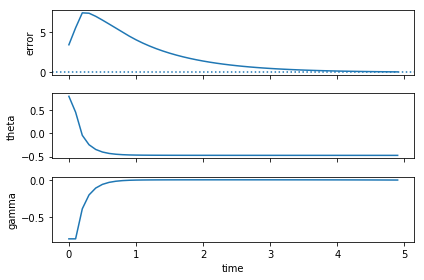

In [19]:
initial_pose = np.eye(3) @ mktr(-8, 3) @ mkrot(0.8)
L = 1
robot = BCRobot(initial_pose, L)
maxsteer = np.pi/4  # we will limit our steering to this range
maxspeed = 5
desired_xy = np.array([0, 0])
speed_controller = PID(1, 0, 0)
gamma_controller = PID(1, 0, 0)

dt = 0.1
ts = np.arange(0, 5, dt)
errors, thetas, gammas = [], [], []

for t in ts:  # we simulate 10 seconds
    x, y = robot.getxy()
    theta = robot.gettheta()

    # position of target in robot frame
    target_rf = np.linalg.inv(robot.pose) @ np.array(
        [[desired_xy[0], desired_xy[1], 1]]).T
    angle_to_target = np.arctan2(target_rf[1, 0], target_rf[0, 0])
    distance_to_target = target_rf[0, 0]

    v = speed_controller.step(distance_to_target, dt)
    v = np.clip(v, -maxspeed, +maxspeed)
    gamma = gamma_controller.step(angle_to_target, dt)
    gamma = np.clip(gamma, -maxsteer, +maxsteer)

    robot.step(v, gamma, dt)

    # Log everything
    errors.append(distance_to_target)
    thetas.append(theta)
    gammas.append(gamma)
    # Draw
    if(t % 1 == 0):
        drawrobot_bicycle(robot.pose, gamma, L)
    else:
        plt.plot(*robot.getxy(), ".k", alpha=0.1)
plt.plot(*desired_xy, "*")
plt.axis("equal")

fig, axs = plt.subplots(nrows=3, sharex=True)
axs[0].plot(ts, errors)
axs[0].axhline(y=0, linestyle=":")
axs[0].set(ylabel="error")
axs[1].plot(ts, thetas)
axs[1].set(ylabel="theta")
axs[2].plot(ts, gammas)
axs[2].set(ylabel="gamma",
           xlabel="time")
plt.tight_layout()

## Why do we need an the "I" in PID?

To answer this question, we simulate a drone that can only move up and down.  The drone has a mass, and its state is given by the height and velocity.  Height changes according to velocity; velocity changes according to acceleration; acceleration depends on the forces acting on the drone; two forces act on our drone:
* `gravity_force` pulls the drone down, and is constant.
* `thrust_force` is pushing the drone up. Picture a propeller or a rocket whose power we control instantaneously.

We build a class that implements this.

In [28]:
class Drone:
    def __init__(self, initial_height, mass):
        self.height = initial_height
        self.mass = mass
        self.v = 0
        
    def step(self, thrust_force, dt):
        gravity_force = -9.8 * self.mass
        force = thrust_force + gravity_force
        acceleration = force / self.mass
        self.v = self.v + acceleration * dt
        self.height = self.height + self.v * dt

Let's now control our drone with a PID controller, in order to reach a desired height.  Note that we limit the max thrust force we can apply.

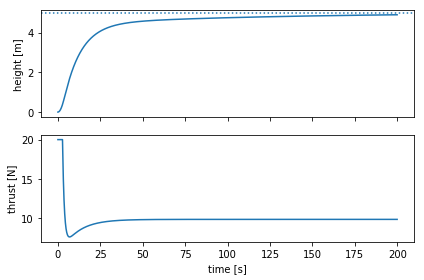

In [26]:
d = Drone(initial_height = 0, mass = 1)
desired_height = 5
maxthrust = 20
thrust_controller = PID(10,0.08,100)

heights, thrusts = [], []
dt = 0.1
ts = np.arange(0,200,dt)
for t in ts:
    height = d.height
    error = desired_height - height
    thrust = thrust_controller.step(error, dt)
    thrust = np.clip(thrust, 0, maxthrust)
    d.step(thrust, 0.01, )
    heights.append(height)
    thrusts.append(thrust)

fig, axs = plt.subplots(nrows=2, sharex=True)
axs[0].plot(ts, heights)
axs[0].axhline(y=desired_height, linestyle = ":")
axs[0].set(ylabel="height [m]")
axs[1].plot(ts, thrusts)
axs[1].set(ylabel="thrust [N]",
           xlabel="time [s]")
plt.tight_layout()

Try playing with the PID gains.
- Start with only $K_p$.  Can you get to some height and stay there without oscillating up and down forever?
- Add $K_d$ to dampen the oscillations.  You should be able to get a relatively good behavior.
- Experiment with different values for the `desired_height`, `mass` and `maxthrust`
- Can you get to the exact desired height? What if you change the mass?
- Once you get decent behavior with $K_p$ and $K_d$, experiment adding some $K_i$.

In [27]:
@ipywidgets.interact(
    Kp=ipywidgets.FloatSlider(min=0, max=100, step=1),
    Ki=ipywidgets.FloatSlider(min=0, max=5, step=0.01),
    Kd=ipywidgets.FloatSlider(min=0, max=50, step=1),
    mass=ipywidgets.FloatSlider(min=0.1, max=2, value=1, step=0.1))
def f(Kp, Ki, Kd, mass):
    d = Drone(initial_height=0, mass=mass)
    desired_height = 5
    maxthrust = 20
    thrust_controller = PID(Kp, Ki, Kd)

    heights, thrusts = [], []
    dt = 0.1
    ts = np.arange(0, 10, dt)
    for t in ts:
        height = d.height
        error = desired_height - height
        thrust = thrust_controller.step(error, dt)
        thrust = np.clip(thrust, 0, maxthrust)
        d.step(thrust, dt)
        heights.append(height)
        thrusts.append(thrust)
    
    fig, axs = plt.subplots(nrows=2, sharex=True)
    axs[0].plot(ts, heights)
    axs[0].axhline(y=desired_height, linestyle = ":")
    axs[0].set(ylabel="height [m]")
    axs[1].plot(ts, thrusts)
    axs[1].set(ylabel="thrust [N]",
               xlabel="time [s]")
    plt.tight_layout()

interactive(children=(FloatSlider(value=0.0, description='Kp', step=1.0), FloatSlider(value=0.0, description='…

### Exercise

One of the reasons the simulation above is not very accurate is that it's not modeling the aerodynamic drag force (i.e. air resistance).  For low speeds, that's proportional to the velocity of the object (careful about the sign!).  Implement it in the simulator above and make sure that its effects are those you expect.